# Aula 07.4 - Bag of Features

# MBA em Ciência de Dados
## Técnicas Avançadas de Captura e Tratamento de Dados


### <span style="color:darkred">Módulo VII - Dados não estruturados: sinais e imagens</span>


### <span style="color:darkred">Bag of Features</span>

Material Produzido por Moacir Antonelli Ponti

CeMEAI - ICMC/USP São Carlos

---

O método **Bag of Features** é um framework genérico para obter descritores aprendidos a partir dos dados.

Quando aplicado em imagens também é chamado de *Bag of Visual Words*

Possui os seguintes passos:

1. extrair características localmente

2. aprender um dicionário de palavras visuais (vocabulário)
    
3. quantizar ou agrupar as características usando o dicionário
    
4. cada imagem é representada pela frequência das palavras visuais (histograma)

Essa técnica teve origem ao mesmo tempo na literatura de texto (Bag of Words) e análise de textura (Textons).

Nesse aula vamos exemplificar usando imagens.

<img src=imagens/textons1.jpg width=720>

Temos 3 imagens, e para cada imagem aprendemos um conjunto de subimagens representativas formando um **dicionário visual** ou *codebook*.

Podemos usar:
* o espaço de pixels original,
* o espaço de pixels projetado utilizando PCA, 
* descritores ou vetores de características extraídos.

A partir de então para cada subimagem, verificamos sua similaridade com o dicionário, e contamos a ocorrência da palavra visual mais similar, formando histogramas que serão utilizados para as tarefas de reconhecimento.

<img src=imagens/textons2.jpg width=720>

--- 
Detalhando o método **Bag of Features**

1. definir um conjunto de características ou descritores base




2. dos dados de treinamento: extrair as características de maneira local em *patches*
    * subimagens
    * trechos de sinais

<img src=imagens/bof1.jpg width=680>

    


3. o espaço de características será formado por múltiplos vetores locais
    * extraídos dos *patches*
    * assim temos múltiplos vetores por imagem ou sinal

<img src=imagens/bof2.jpg width=680>    



    
4. montar um *codebook* ou *dicionário* obtido a partir de todo o universo de vetores de treinamento, 
    1. definir o tamanho do dicionário $K$
    2. executar um algoritmo de agrupamento e definir os centros dos $K$ clusters como elementos do dicionário

<img src=imagens/bof3.jpg width=680>    

    


5. o vetor de características é um histograma obtido da seguinte forma:
    1. o histograma tem um *bin* para cada elemento do dicionário
    2. extraia o próximo *patch*
    3. conte +1 ao código do dicionário mais similar ao *patch* extraído

<img src=imagens/bof4.jpg width=680>    


---
### Passo 1 - obter imagens e patches

Vamos usar a função `extract_patches_2d()` da `sklearn.feature_extraction.image`

Várias outras bibliotecas serão utilizadas. Alguns destaques:
* joblib: Parallel, delayed - permite executar uma função em modo paralelo
* os: listdir - para listar arquivos numa pasta

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from imageio.v2 import imread
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from joblib import Parallel, delayed


def get_patches(img_file, random_state, tam_patch=(11, 11), n_patches=250):
    '''Extração de subimagens a partir de uma imagem
       Parametros
           img_file: caminho para a imagem
           random_state: semente aleatoria
           tam_patches: tamanho de cada subimagem
           n_patches: numero maximo de subimagens a extrair
    '''

    img = imread(img_file)
    
    # Extrai subimagens
    patch = extract_patches_2d(img, 
                               patch_size=tam_patch,
                               max_patches=n_patches, 
                               random_state=random_state)
    
    return patch.reshape((n_patches, 
                          np.prod(tam_patch) * len(img.shape)))

Temos que definir:
* o tamanho de cada patch e o total de patches
* o diretório a buscar imagens
* cada patch terá ainda uma dimensão extra, relativa ao número de canais de cor (1 para cinza, 3 para RGB) 

Patches extraídos para criação do dicionário de features
Total de imagens =  80
Tamanho de cada array de patches =  (1000, 507)


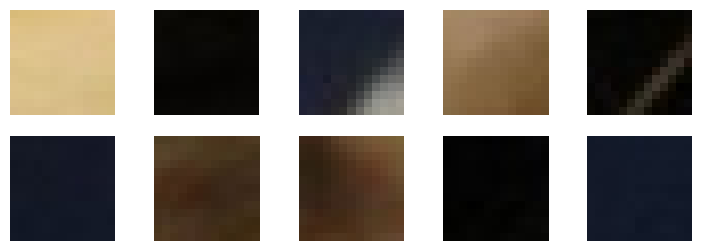

In [2]:
# Parametros do BOF
tam_patch = (13, 13)
n_patches = 1000
path_imgs = './dados/flickr_map_training/'
random_state = 1
# pega lista de arquivos no caminho
l_imgs = listdir(path_imgs)

# total de imagens
n_imgs = len(l_imgs)

# Extrai patches de cada imagem, de forma paralela para cada imagem
# retorna uma lista do mesmo tamanho do número de imagens
patch_arr = Parallel(n_jobs=-1)(delayed(get_patches)(path_imgs+arq_img, 
                                                    random_state,
                                                    tam_patch,
                                                    n_patches)
                                for arq_img in l_imgs)

print('Patches extraídos para criação do dicionário de features')
print('Total de imagens = ', len(patch_arr))
print('Tamanho de cada array de patches = ', patch_arr[0].shape)

# exibe alguns patches de uma imagem
img_ind = 1
plt.figure(figsize=(9,3))
for i in np.arange(1,11):
    plt.subplot(2,5,i)
    plt.imshow(patch_arr[img_ind][i].reshape((tam_patch[0],tam_patch[1],3)))
    plt.axis('off')

---
### Passo 2 - obter features a partir dos patches

Como o número de pixels em cada patch é de alta dimensionalidade, podemos extrair features para tornar o vetor mais compacto.

Aqui utilizamos o PCA como extrator de características

In [3]:
pca_components = 20

# Criando matriz com todos os patches para aplicar PCA
patch_arr2 = np.array(patch_arr, copy=True)
patch_arr2 = patch_arr2.reshape((patch_arr2.shape[0] * patch_arr2.shape[1],
                               patch_arr2.shape[2]))

print('Total de instancias = ', len(patch_arr2), ' de tamanho = ', patch_arr2[0].shape[0])

# Construindo modelo de componentes principais
modelo_PCA = PCA(n_components=pca_components, random_state=random_state)
modelo_PCA.fit(patch_arr2)
patch_pca = modelo_PCA.transform(patch_arr2)

print('Espaço de características PCA criado')

print('\tpatches = ', len(patch_pca), ' de tamanho = ', patch_pca[0].shape[0])

Total de instancias =  80000  de tamanho =  507
Espaço de características PCA criado
	patches =  80000  de tamanho =  20


---
### Passo 3 - obter Dicionário / Codebook / Vocabulário

Para isso utilizaremos o KMeans. É preciso definir:
* o número de palavras visuais no vocabulário
    * o padrão é um valor entre 50 e 1000 elementos
    

In [4]:
n_dic = 32
random_state = 1

# Construindo o dicionário
kmeans_model = KMeans(n_clusters=n_dic, 
                      verbose=False, 
                      init='random',
                      random_state=random_state, 
                      n_init=3)
kmeans_model.fit(patch_pca)

print('Dicionário aprendido')

Dicionário aprendido


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
      dtype=int32)

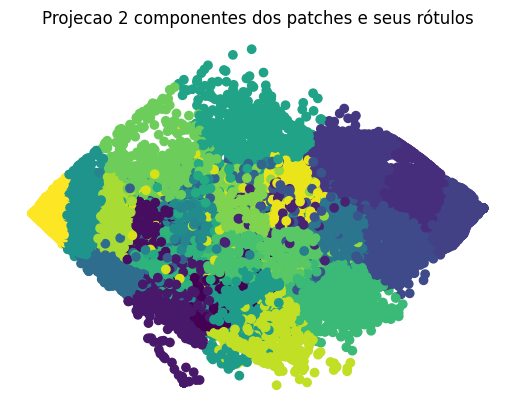

In [5]:
plt.scatter(patch_pca[:, 0], patch_pca[:, 1], c=kmeans_model.labels_)
plt.title('Projecao 2 componentes dos patches e seus rótulos')
plt.axis('off')

np.unique(kmeans_model.labels_)

---
### Passo 4 - obter histogramas como features da Bag of Featurees

Sabemos que cada uma das `n_imgs` imagens possui número de patches = `n_patches`

Vamos agora verificar a frequência de cada palavra visual no dicionário em cada uma das imagens de treinamento

In [6]:
img_feats = []

# para cada imagem
for i in range(n_imgs):
    # predicao para os n_patches de uma imagem
    y = kmeans_model.predict(patch_pca[i*n_patches: (i*n_patches)+n_patches])

    # computa histograma e armazena no array de features
    hist_bof,_ = np.histogram(y, bins=range(n_dic+1), density=True)
    img_feats.append(hist_bof)

img_feats = np.array(img_feats, copy=False)
print('Número de imagens e features = ', img_feats.shape)

Número de imagens e features =  (80, 32)


O array `img_feats` é um índice com características para cada imagem

---
### Passo 5 - utilizar as features para tarefas de reconhecimento

Aqui vamos usar para *recuperação de imagem baseada em conteúdo*, a partir de uma imagem de consulta.

Mas essas features podem ser usadas para realizar treinamento de modelos ou outras análises.

Patches extraídos
(1000, 507)
PCA executado
(1000, 20)
Features do BOF obtidas
Distancias calculadas
imagem mais similar = 39  distancia = 0.254161366064947


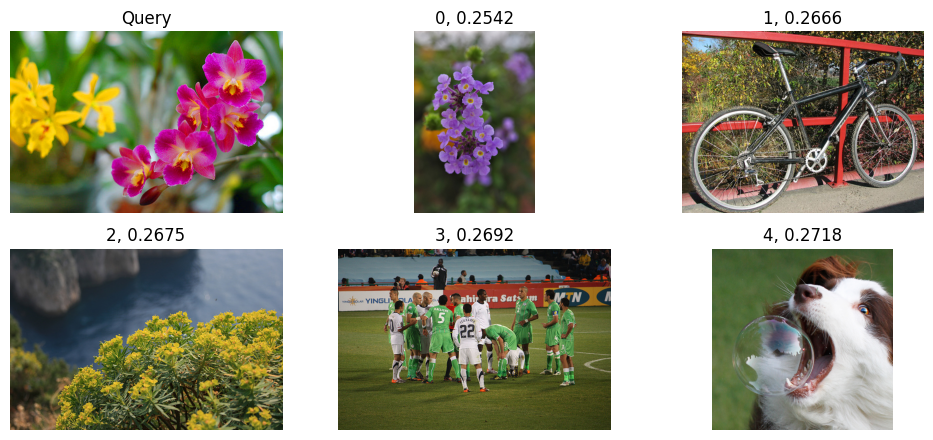

In [7]:
path_query = './dados/flickr_map_test/flower.jpg'
# pegando patches
query_patches = get_patches(path_query, random_state, tam_patch, n_patches)
query_patches = np.array(query_patches, copy=False)
print('Patches extraídos')
print(query_patches.shape)

# redimensionando e aplicando pca
query_pca = modelo_PCA.transform(query_patches)
print('PCA executado')
print(query_pca.shape)

# obtem palavras visuais
y = kmeans_model.predict(query_pca)
# computa histograma como feature
query_feats,_ = np.histogram(y, bins=range(n_dic+1), density=True)

print('Features do BOF obtidas')

dists = []
for i in range(n_imgs):
    diq = np.sqrt(np.sum((img_feats[i]-query_feats)**2))
    dists.append(diq)

# pega imagens mais proximas    
k_cbir = np.argsort(dists)[:5]

print('Distancias calculadas')
print('imagem mais similar =', k_cbir[0], ' distancia =', dists[k_cbir[0]])

import imageio.v2 as imageio
imgq = imageio.imread(path_query)

plt.figure(figsize=(12,8))
plt.subplot(331); plt.imshow(imgq)
plt.title('Query'); plt.axis('off')

imgs = []
for i in range(5):
    imgs.append(imageio.imread(path_imgs+l_imgs[k_cbir[i]]))
    plt.subplot(3,3,i+2); plt.imshow(imgs[i])
    plt.title('%d, %.4f' % (i, dists[k_cbir[i]])); plt.axis('off')


### Resumo:

* Bag of Features é um *framework* para obter características
    * útil para obter representações compactas e com certo grau de interpretabilidade
    * estado da arte pré-Deep Learning

* Etapas críticas
    * definição do descritor base
    * definição do dicionário
    
* Pode ser usado para qualquer dado não estruturado, seguindo as mesmas etapas
    * texto - Bag of Words
    * sinais
    * outros